# Demo on distance measurement involving HPC at home

Task formulation: given $n$ points in $R^d$ find the $k\ll n$ closest neighbors of all points (both indices and distances)

In [1]:
# load dependencies
import packaging
import time

import numpy as np

import scipy
from scipy.spatial import cKDTree, distance
from scipy.stats import norm, uniform, special_ortho_group
from sklearn.utils import check_random_state

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# presentation colors
gray = (0.8, 0.8, 0.8)
params = {"ytick.color" : gray,
          "xtick.color" : gray,
          "text.color" : gray,
          "figure.facecolor": "black",
          "legend.facecolor": (0,0,0,0),
          "axes.facecolor": (0,0,0,0),
          "axes.labelcolor" : gray,
          "axes.edgecolor" : gray}
plt.rcParams.update(params)

## Make data

Define some simple geometries:
- $n$: number of points
- $D$: dimension of the embedding space
- $d$: dimension of the related geometrical object
- seed: random state or seed for reproducibility

In [3]:
def hypercube(n: int, D: int, d: int, seed=None) -> np.ndarray:
    """hypercube of d-dimensions, parallel with main axes"""
    rs = check_random_state(seed)
    choices = rs.choice(D, size=d, replace=False)
    out = np.zeros((n, D))
    out[:, choices] = uniform.rvs(0, 1, size=(n, d), random_state=rs)
    return out

def hypersphere(n: int, D: int, d: int, seed=None) -> np.ndarray:
    """surface of a d-ball (a (d-1)-dimensional mannifold)"""
    rs = check_random_state(seed)
    choices = rs.choice(D, size=d, replace=False)
    out = np.zeros((n, D))
    out[:, choices] = norm.rvs(0, 1, size=(n, d), random_state=rs)
    out /= np.linalg.norm(out, axis=1, keepdims=True)
    return out

def standard_normal(n: int, D: int, d: int, seed=None) -> np.ndarray:
    """independent standard normal values in d dimension"""
    rs = check_random_state(seed)
    choices = rs.choice(D, size=d, replace=False)
    out = np.zeros((n, D))
    out[:, choices] = norm.rvs(0, 1, size=(n, d), random_state=rs)
    return out

def distorted_normal(n: int, D: int, d: int, seed=None, ratio=1.1) -> np.ndarray:
    """slightly deformed normal with randomly pointing axes"""
    rs = check_random_state(seed)
    out = np.zeros((n, D))
    lambdas = np.power(ratio, np.arange(d))
    # we could use scipy.stats.mvn (multivariate-normal)
    # with an appropriate Sigma matrix
    out[:, :d] = norm.rvs(0, lambdas, size=(n, d), random_state=rs)
    rotation = special_ortho_group.rvs(D, random_state=rs)
    assert np.allclose(np.dot(rotation, rotation.T), np.eye(D))
    return np.dot(out, rotation.T)

def stick_like(n: int, D: int, d: int, seed=None, rotate=True) -> np.ndarray:
    return distorted_normal(n, D, d, seed=seed, ratio=2.0)

AVAILABLE_GEOMETRY = {
    'cube': hypercube,
    'sphere': hypersphere,
    'norm': standard_normal,
    'n.elli': distorted_normal,
    'stick': stick_like
}

In [4]:
# perform a basic validity check
from sklearn.decomposition import PCA
pca=PCA(n_components=None)
pca.fit(distorted_normal(10000, 3, 2))
np.sqrt(pca.explained_variance_)  # should be lambdas

array([1.09354307e+00, 1.01106485e+00, 9.10702438e-17])

In [5]:
# perform a basic validity check
np.sqrt(np.sum(np.square(hypersphere(10, 4, 2)), axis=1))  # should be 1s

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
def make_data(ns: list=None, Ds: list=None, ds: list=None,
              geometries: dict=None, seed=20231108):
    """Create a suite of test data"""
    from itertools import product as iter_prod
    if ns is None:
        ns = [100, 1000, 10000]
    if Ds is None:
        Ds = [1, 2, 3, 5, 8, 13, 21, 30]
    if ds is None:
        ds = [1, 2, 3, 5, 8, 13, 21, 30]
    if geometries is None:
        geometries = AVAILABLE_GEOMETRY.copy()
        geometries.pop('stick')
    data = {}
    for n, D, d, name in iter_prod(ns, Ds, ds, geometries):
        if d == 0:
            d = D  #
        geometry = geometries[name]
        try:
            tmp = geometry(n, D, d, seed=seed)
        except:
            pass
        else:
            data[name, n, D, d] = tmp
    return data

In [7]:
test_data = make_data()
len(test_data)

429

(<Figure size 750x140 with 5 Axes>,
 array([<Axes: title={'center': 'cube'}>,
        <Axes: title={'center': 'sphere'}>,
        <Axes: title={'center': 'norm'}>,
        <Axes: title={'center': 'n.elli'}>,
        <Axes: title={'center': 'stick'}>], dtype=object))

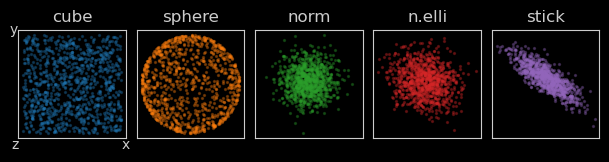

In [8]:
# Visualize data for the presentation
def plot_demo_data(fn=None):
    seed = 271
    methods = AVAILABLE_GEOMETRY
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots(1, len(methods), figsize=(len(methods) * 1.5, 1.4),
                           gridspec_kw={'wspace': 0.1})
    for a, c, name in zip(ax, colors, methods):
        tmp = methods[name](1000, 3, 3, seed=seed)
        a.scatter(tmp[:, 0], tmp[:, -1], s=2, c=c, alpha=0.3)
        a.set_xticks([])
        a.set_yticks([])
        a.axis('equal')
        # a.set_aspect('equal', 'box')
        a.set_title(name)
    ax[0].text(1, 0, 'x', transform=ax[0].transAxes, va='top', ha='center')
    ax[0].text(0, 1, 'y', transform=ax[0].transAxes, va='center', ha='right')
    ax[0].text(0, 0, 'z', transform=ax[0].transAxes, va='top', ha='right')
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', transparent=True)
    return fig, ax
        
plot_demo_data('datasets_3d.pdf')

## Measure time

In [9]:
class OurTimer(object):
    """
    Measure cpu times larger than 100ms and clock times,
    as well as collect exception info, if any
    """
    def __init__(self, ignore_errors=True):
        self.ignore_errors = ignore_errors
        self.proc_start = None
        self.clock_start = None
        self.proc_end = None
        self.clock_end = None
        self.exception = None
        
    def __enter__(self):
        self.proc_start = time.process_time_ns()
        self.clock_start = time.perf_counter_ns()
        self.proc_end = None
        self.clock_end = None
        self.exception = None
        return self
        
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type is None:
            self.proc_end = time.process_time_ns()
            self.clock_end = time.perf_counter_ns()
            return
        self.exception = str(exc_value)
        return (self.ignore_errors and  # suppress exceptions
                not issubclass(exc_type, KeyboardInterrupt))
        
    def get_times(self):
        try:
            return (
                # process does not include GPU
                # resolution may be as low as 16ms
                self.proc_end-self.proc_start,
                # clock resolution is quite good
                self.clock_end-self.clock_start,
                None
            )
        except TypeError:
            return None, None, self.exception

In [66]:
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

def measure_time(method: callable, test_data: dict, *,
                 variant: str=None, p_norm: float=2.0,
                 dtype=None, ignore_errors=True):
    """Measure performance on test_data. Return result as pd.Dataframe."""
    measurement = {}
    try:
        for key, value in tqdm(test_data.items()):
            if dtype is not None:
                value = value.astype(dtype)
            with OurTimer(ignore_errors) as ot:
                _ = method(points=value, queries=value,
                           k=np.int32(10), p_norm=value.dtype.type(p_norm))
            proc, clk, err = ot.get_times()
            measurement[key + (method.__name__, variant, str(dtype))] = proc * 1e-9, clk * 1e-9, err
    except KeyboardInterrupt:
        pass  # keep already calculated
    df = pd.DataFrame(measurement, index=['proc', 'clk', 'err']).T
    df.index.names = ['geometry', 'n', 'D', 'd', 'method', 'variant', 'dtype']
    return df.reset_index()

In [11]:
def plot_time(data: pd.DataFrame, fn=None, *, hue='geometry', palette=None):
    """Plot clock time based on previous measurement"""
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.lineplot(data=data, x='d', hue=hue, style='n', y='clk', palette=palette, ax=ax)
    ax.set_ylabel('clock [s]')
    ax.tick_params(which='both', right=True, top=True)
    ax.semilogy()  # ax.loglog() seems less readable here
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', transparent=True)
    return fig, ax

In [67]:
def collect_data(names: list):
    collected = []
    for name in names:
        tmp = pd.read_csv(name)
        collected.append(tmp)
    return pd.concat(collected, axis=0)

# Out-of the box: KDTree

- [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html)
- quite involved to implement manually
- "For large dimensions (20 is already large) do not expect this to run significantly faster than brute force. High-dimensional nearest-neighbor queries are a substantial open problem in computer science."
- there are approximate solutions used in machine learning (e.g., [1](https://ignite.apache.org/docs/latest/machine-learning/binary-classification/ann), [2](https://github.com/DBAIWangGroup/SRS), etc.), but they may not be suited for our data

In [12]:
def cpu_scipy_kdtree(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    """
    Calculate the local neighbor distances on the manifold using a k-D
    tree search. Only the requested number of neighbors are retrieved.
    """
    tree_of_points = cKDTree(points, copy_data=False)

    n_jobs = -1  # use all cores
    if packaging.version.parse(scipy.__version__) < packaging.version.parse("1.9"):
        kw = {'n_jobs': n_jobs}
    else:
        kw = {'workers': n_jobs}

    distances, neighbor_idx = tree_of_points.query(
        queries, k, p=p_norm, **kw)

    return neighbor_idx, distances

  0%|          | 0/114 [00:00<?, ?it/s]

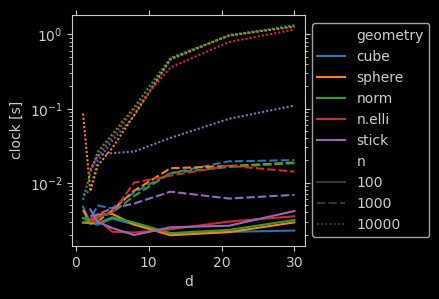

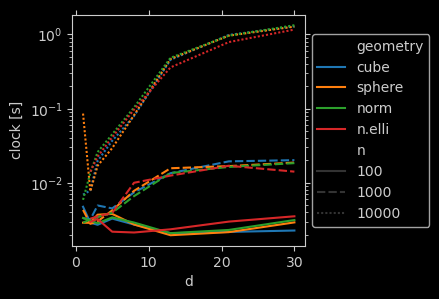

In [69]:
# test all geometries
res = measure_time(cpu_scipy_kdtree,
                   make_data(ds=[0], geometries=AVAILABLE_GEOMETRY),
                   variant='kdtree')
plot_time(res, 'kdtree_stick.pdf')
# just to show: "stick" gives an unfair advantage to this method because
# all dimensions provide approximately the same info, we won't use "stick"
plot_time(res.loc[res.geometry != 'stick'], 'kdtree_basic.pdf')
res.loc[res.geometry == 'cube'].to_csv('kdtree_basic.csv')

# Numpy strategies

Let's explore that phrase about efficiency.

We calculate the distance between all pairs of points (brute force)
- big step: distance between all pairs in a single step
- row-wise: completely process a few query at a time
- tiling: process a batch of queries and a batch of possible neighbors

Note:
- [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) implements many more distances, although optimized for speed, it calculates all pairs so it still requires a lot of memory

In [89]:
# let's first do a naive implementetion

def pairwise_distance(
    points: np.ndarray, queries: np.ndarray, p_norm: float
):
    """
    points: shape (m_points, d)
    queries: shape (n_queries, d)
    p_norm: float
    return shape (n_queries, m_points)
    """
    distances = np.linalg.norm(
        queries[:, np.newaxis] - points[np.newaxis, :],
        ord=p_norm, axis=-1)
    return distances

def smallest_k_idx(
    arr: np.array, k: int
):
    """
    Indices that sort the smallest k elements along last axis
    arr: shape (n_samples, n_elements)
    See also Selection algortihms https://en.wikipedia.org/wiki/Selection_algorithm
    """
    idx = np.argsort(arr, axis=-1)[..., :k]
    return idx
    
def cpu_numpy_brute(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    """
    Calculate the local neighbor distances on the manifold using
    brute-force search. The vectorial differnce and the distance
    of all neighbors is retrieved and stored in memory (!), then sorted.
    """
    # there is no-broadcast-and-reduce operation in numpy,
    # therefore we have to store the difference vectors in memory
    # distances = np.linalg.norm(
    #    queries[:, np.newaxis] - points[np.newaxis, :],
    #    ord=p_norm, axis=-1)
    distances = pairwise_distance(points, queries, p_norm)
    # neighbor_idx = np.argsort(distances, axis=-1)[:, :k]
    neighbor_idx = smallest_k_idx(distances, k)
    distances = np.take_along_axis(distances, neighbor_idx, axis=-1)
    return neighbor_idx, distances

def cpu_scipy_brute(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    """
    Calculate the local neighbor distances on the manifold using
    brute-force search. The distance of all neighbors is retrieved and
    stored in memory (!) then sorted.
    """
    distances = distance.squareform(distance.pdist(queries, 'minkowski', p=p_norm))
    idx = np.argsort(distances, axis=-1)
    neighbor_idx = idx[:, :k]
    distances = np.take_along_axis(distances, neighbor_idx, axis=-1)
    return neighbor_idx, distances

def cpu_numpy_tile(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    """
    Calculate the local neighbor distances on the manifold using
    brute-force search with a tile pattern. Distances of k+batch_size
    points are stored for each query and sorted after processing each
    tile. This results in a runtime O(n log max(k, batch_size)) per query
    that is comparable to using a binary search tree and is also memory
    efficient. Another advantage is memory locality.
    See details in the comments.
    This batch version is the ideal candidate to be optimized for GPU.
    """

    N, M = len(queries), len(points)
    k = k

    # X closest neighbor distances
    distances = np.zeros((N, k), dtype=float)
    neighbor_idx = np.zeros((N, k), dtype=np.int64)

    # for a code written in C the outer batch size should be 1
    # here we want to minimize the use of the interpreter
    batch_size_i = 64
    # N seems to be suboptimal (too large)
    batch_size_j = np.maximum(batch_size_i, k)
    # b=batch_size, B=batch_size+k
    # ordering: call N/b times O(2B*log(2B)) algorithm,
    #   ~O(2*log(2)*N*log(b)) instead of full sorting at O(N*log(N))
    dists_tmp = np.empty((batch_size_i, k + batch_size_j), dtype=float)
    inds_tmp = np.empty((batch_size_i, k + batch_size_j), dtype=np.int64)
    for i1 in range(0, N, batch_size_i):
        i2 = np.minimum(i1 + batch_size_i, N)
        count_i = i2 - i1
        dists_tmp[()] = np.inf
        inds_tmp[()] = -1
        for j1 in range(0, M, batch_size_j):
            j2 = np.minimum(j1 + batch_size_j, M)
            count_j = j2 - j1
            inds_tmp[:i2 - i1, k:k + j2 - j1] = np.arange(j1, j2)
            dists_tmp[:i2 - i1, k:k + j2 - j1] = pairwise_distance(
                points[j1:j2], queries[i1:i2], p_norm)
            order = smallest_k_idx(dists_tmp[:, :k + j2 - j1], k)
            # we may not care about the overhead in i,
            # but have to be careful about j: do not duplicate
            # neighbor from the batch before the last one
            inds_tmp[:, :k] = np.take_along_axis(inds_tmp, order, axis=-1)
            dists_tmp[:, :k] = np.take_along_axis(dists_tmp, order, axis=-1)
        distances[i1:i2, :] = dists_tmp[:i2 - i1, :k]
        neighbor_idx[i1:i2, :] = inds_tmp[:i2 - i1, :k]

    return neighbor_idx, distances

def cpu_numpy_row(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    """
    Calculate the local neighbor distances on the manifold using
    brute-force search with a row-scan pattern. All distances for a query
    at a time are stored so this is quite memory efficient, sorting
    takes an almost optimal O(n log n) time but the main advantage is
    the simplicity of the algorithm.
    This batch version could be optimized for GPU.
    """

    queries = np.asarray(queries)
    N, M = len(queries), len(points)

    # X closest neighbor distances
    distances = np.zeros((N, k), dtype=float)
    neighbor_idx = np.zeros((N, k), dtype=np.int64)

    for i in range(N):
        dists_tmp = pairwise_distance(points, queries[i:i+1], p_norm)[0]
        # inds_tmp = np.argsort(dists_tmp)[:k]
        inds_tmp = smallest_k_idx(dists_tmp, k)
        neighbor_idx[i, :] = inds_tmp
        distances[i, :] = dists_tmp[inds_tmp]

    return neighbor_idx, distances

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

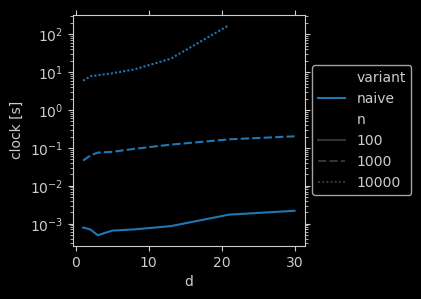

In [16]:
res = pd.read_csv('brute_naive.csv', index_col=0)
plot_time(res, 'brute_1_naive.pdf', hue='variant')

In [93]:
import cProfile

with cProfile.Profile() as pr:
    measure_time(cpu_numpy_brute, make_data(ns=[1000], Ds=[10], ds=[0], geometries={'cube': hypercube}), ignore_errors=False)
    pr.print_stats(sort='cumtime')

  0%|          | 0/1 [00:00<?, ?it/s]

         26984 function calls (24579 primitive calls) in 0.320 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.319    0.319 2863373997.py:6(measure_time)
        1    0.000    0.000    0.270    0.270 2226410710.py:28(cpu_numpy_brute)
   104/69    0.009    0.000    0.194    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.077    0.077    0.149    0.149 2226410710.py:3(pairwise_distance)
        1    0.000    0.000    0.120    0.120 2226410710.py:17(smallest_k_idx)
        1    0.000    0.000    0.120    0.120 <__array_function__ internals>:177(argsort)
        1    0.000    0.000    0.119    0.119 fromnumeric.py:1038(argsort)
        1    0.000    0.000    0.119    0.119 fromnumeric.py:51(_wrapfunc)
       13    0.119    0.009    0.119    0.009 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.072    0.072 <__array_fun

In [17]:
from numba import jit

@jit(nopython=True, fastmath=True, error_model='numpy')
def pairwise_distance(
    points: np.ndarray, queries: np.ndarray, p_norm: float
):
    """
    points: shape (m_points, d)
    queries: shape (n_queries, d)
    p_norm: float
    return shape (n_queries, m_points)
    """
    M, d_ = points.shape
    N, d = queries.shape
    result = np.zeros((N, M), dtype=float)
    for i in range(N):
        for j in range(M):
            dist = np.sum(np.power(np.abs(queries[i] - points[j]), p_norm))
            # dist = 0.
            # for k in range(d):
            #    dist += pow(abs(queries[i, k] - points[j, k]), p_norm)
            result[i, j] = dist
    return np.power(result, 1./p_norm)

In [18]:
# make sre our implementation works
tmp = np.random.uniform(size=(10, 100))
assert np.all(np.argsort(tmp, axis=-1)[:, :5] == smallest_k_idx(tmp, 5))

In [19]:
# this takes a few minutes
res = measure_time(cpu_numpy_brute, make_data(ds=[0], geometries={'cube': hypercube}),
                   variant='compiled', ignore_errors=False)
res.to_csv('brute_compiled.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

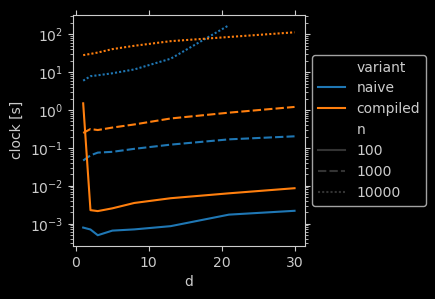

In [72]:
res = pd.read_csv('brute_compiled.csv', index_col=0)
collected = collect_data(['brute_naive.csv', 'brute_compiled.csv'])
plot_time(collected, 'brute_2_compiled.pdf', hue='variant')

In [21]:
from numba import jit

@jit(nopython=True, fastmath=True, error_model='numpy')
def pairwise_distance(
    points: np.ndarray, queries: np.ndarray, p_norm: float
):
    """
    points: shape (m_points, d)
    queries: shape (n_queries, d)
    p_norm: float
    return shape (n_queries, m_points)
    """
    M, d_ = points.shape
    N, d = queries.shape
    result = np.zeros((N, M), dtype=float)
    for i in range(N):
        for j in range(M):
            dist = np.sum(np.square(queries[i] - points[j]))
            # dist = np.sum((queries[i] - points[j]) ** 2)
            result[i, j] = dist
    return np.sqrt(result)

In [22]:
res = measure_time(cpu_numpy_brute, make_data(ds=[0], geometries={'cube': hypercube}),
                   variant='np_square', ignore_errors=False)
res.to_csv('brute_np_square.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

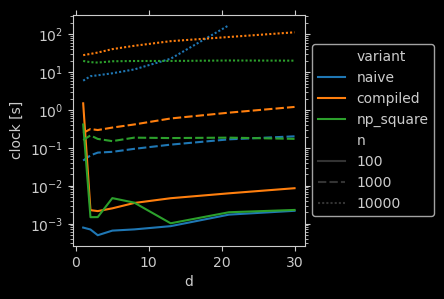

In [74]:
res = pd.read_csv('brute_np_square.csv')
collected = collect_data(['brute_naive.csv', 'brute_compiled.csv', 'brute_np_square.csv'])
plot_time(collected, 'brute_3_np_square.pdf', hue='variant')

In [24]:
from numba import jit

@jit(nopython=True, fastmath=True, error_model='numpy')
def pairwise_distance(
    points: np.ndarray, queries: np.ndarray, p_norm: float
):
    """
    points: shape (m_points, d)
    queries: shape (n_queries, d)
    p_norm: float
    return shape (n_queries, m_points)
    """
    M, d_ = points.shape
    N, d = queries.shape
    result = np.zeros((N, M), dtype=float)
    for i in range(N):
        for j in range(M):
            # dist = 0.
            # for k in range(d):
            #     dist += np.square(queries[i, k] - points[j, k])
            dist = 0.
            for k in range(d):
                dist += (queries[i, k] - points[j, k]) ** 2  # better than array
            result[i, j] = dist
    return np.sqrt(result)

In [25]:
res = measure_time(cpu_numpy_brute, make_data(ds=[0], geometries={'cube': hypercube}),
                   variant='op_square', ignore_errors=False)
res.to_csv('brute_op_square.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

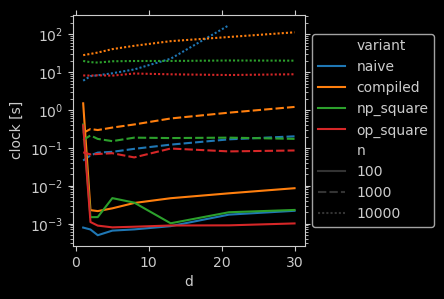

In [76]:
res = pd.read_csv('brute_op_square.csv')
collected = collect_data(['brute_naive.csv', 'brute_compiled.csv', 'brute_np_square.csv',
                          'brute_op_square.csv'])
plot_time(collected, 'brute_4_op_square.pdf', hue='variant')

In [27]:
def smallest_k_idx(
    arr: np.array, k: int
):
    """
    Indices that sort the smallest k elements along last axis
    arr: shape (n_samples, n_elements)
    See also Selection algortihms https://en.wikipedia.org/wiki/Selection_algorithm
    """
    idx = np.argpartition(arr, k)[..., :k]
    top = np.take_along_axis(arr, idx, axis=-1)
    order = np.argsort(top, axis=-1)
    return np.take_along_axis(idx, order, axis=-1)

In [28]:
res = measure_time(cpu_numpy_brute, make_data(ds=[0], geometries={'cube': hypercube}), ignore_errors=False)
res.to_csv('brute_selection.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

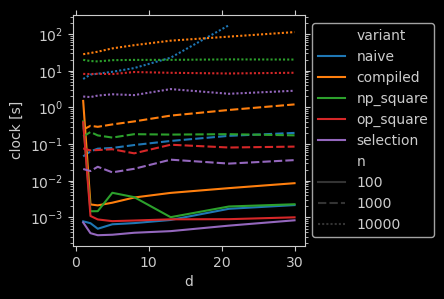

In [78]:
res = pd.read_csv('brute_selection.csv')
collected = collect_data(['brute_naive.csv', 'brute_compiled.csv', 'brute_np_square.csv',
                          'brute_op_square.csv', 'brute_selection.csv'])
plot_time(collected, 'brute_5_selection.pdf', hue='variant')

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

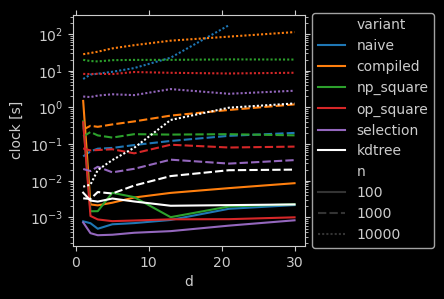

In [79]:
collected = collect_data(['brute_naive.csv', 'brute_compiled.csv', 'brute_np_square.csv',
                          'brute_op_square.csv', 'brute_selection.csv', 'kdtree_basic.csv'])
plot_time(collected, 'brute_6_kdtree.pdf', hue='variant',
          palette={'naive': 'tab:blue', 'compiled': 'tab:orange',
                   'np_square': 'tab:green', 'op_square': 'tab:red',
                   'selection': 'tab:purple', 'kdtree': 'white'})

# Compiling for GPU with numba

- [endorsed by Nvidia](https://developer.nvidia.com/how-to-cuda-python): [numba.cuda](https://numba.pydata.org/numba-doc/latest/cuda/index.html)

Pros:
- supports many low-level CUDA features
- numba [disallows](https://numba.readthedocs.io/en/stable/cuda/cudapysupported.html#numpy-support) any memory allocating features
- support most numpy array API and understand many [ufuncs](https://numba.readthedocs.io/en/stable/cuda/cudapysupported.html#numpy-support)

Cons:
- one has to write "[CUDA kernels](https://numba.readthedocs.io/en/stable/cuda/kernels.html)"
- no access to numpy array functions (scalar operations only)

Notes:
- [guide for SIMD](https://github.com/numba/numba-examples/blob/master/notebooks/simd.ipynb) and optimization

Additional requirements to conda base:
```sh
conda/pip install cudatoolkit
```

In [81]:
from numba import cuda

# Our first and naive implementation, that rus really slow
@cuda.jit(fastmath=True)
def _distances_row(points, queries, indices, distances, p_norm, r_norm):
    """
    CUDA kernel to calculate the local neighbor distances on the manifold
    using brute-force search with a row-scan pattern.
    """
    M = points.shape[0]
    N = queries.shape[0]
    k = distances.shape[1]
    d = points.shape[1]
    p_norm_ = p_norm
    r_norm_ = r_norm

    i1 = cuda.grid(1)
    if N <= i1:
        return
    # todo improve cache hit by sync kernels in j1 time-to-time (not each step)
    for j1 in range(M):
        # calculate quantity related to norm
        dist = 0.
        for d_ in range(d):
            dist += pow(abs(points[j1, d_] - queries[i1, d_]), p_norm_)
        dist = pow(dist, r_norm_)
        # perform insertion sort
        pos = k
        while (0 < pos) and (dist < distances[i1, pos - 1]):
            pos -= 1
        if pos == k:
            continue
        for p_ in range(k - 1, pos, -1):
            distances[i1, p_] = distances[i1, p_ - 1]
            indices[i1, p_] = indices[i1, p_ - 1]
        distances[i1, pos] = dist
        indices[i1, pos] = j1

def _prep_gpu_arrays(points_h: np.ndarray, queries_h: np.ndarray, k: int, p_norm: float):
    N = queries_h.shape[0]
    threads_per_block = 128
    blocks_per_grid = (N + threads_per_block - 1) // threads_per_block
    # note: min_scalar_type for positive values is unsigned,
    # but we don't care if -1 is converted, it "visualizes" "invalid" index
    indices_h = np.full((N, k), -1, dtype=np.min_scalar_type(N))
    # for operators to be available points, queries and p_norm has to be the same type
    common_type = np.common_type(points_h, queries_h)
    distances_h = np.full((N, k), np.inf, dtype=common_type)
    # move arrays to GPU
    indices_d = cuda.to_device(indices_h)
    distances_d = cuda.to_device(distances_h)
    points_d = cuda.to_device(points_h.astype(common_type))
    queries_d = cuda.to_device(queries_h.astype(common_type))
    p_norm_d = np.float16(1) * common_type(p_norm)
    r_norm_d = np.float16(1) / common_type(p_norm)
    conf = blocks_per_grid, threads_per_block
    args = [points_d, queries_d, indices_d, distances_d,
            p_norm_d, r_norm_d]
    return conf, args

def gpu_numba_row(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0
):
    conf, args = _prep_gpu_arrays(points, queries, k, p_norm)
    _distances_row[conf](*args)
    indices_d, distances_d = args[2:4]
    del args
    indices_h = indices_d.copy_to_host()
    distances_h = distances_d.copy_to_host()
    del indices_d, distances_d
    cuda.synchronize()  # try to free memory
    return indices_h, distances_h

In [82]:
# Check CUDA and GPU availability
# don't forget to "conda/pip install cudatoolkit"
list(cuda.gpus)

In [83]:
cuda.current_context().device

<weakproxy at 0x0000024BC5B872E0 to Device at 0x0000024BC5BB5B10>

In [84]:
# Look into the instructions created by the compiler

def find_instr(func, keyword, sig=0, limit=10):
    """Search for specific instructions"""
    # See https://github.com/numba/numba-examples/blob/master/notebooks/simd.ipynb
    count = 0
    instr = func.inspect_asm(func.signatures[sig]).split('\n')
    for i, l in enumerate(instr):
        if keyword in l:
            count += 1
            print(i, l)
            if count >= limit:
                break
    if count == 0:
        print('No instructions found')
    return count

def test_numba_parallelism(wrapper=gpu_numba_row, fun=_distances_row, dtype=float):
    """Try to find parallel and packed instructions"""
    # make minimalist data of small type
    points = (np.arange(10)[:, np.newaxis] + [-5, 5]).astype(dtype)
    # run the code to do jit
    tmp = gpu_numba_row(points, points, 3, 2.0)
    # available signatures of the jit-ted function
    print(fun.signatures)
    # look for optimal instructions
    # we don't want to see 64-bit operations as they are slower
    # we are happy to see vectorized operations (if supported)
    para = find_instr(fun, 'add')
    para = find_instr(fun, 'mul')
    
test_numba_parallelism()

C:\ProgramData\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[(Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'C', False, aligned=True), Array(uint8, 2, 'C', False, aligned=True), Array(float64, 2, 'C', False, aligned=True), float64, float64)]
10 .address_size 64
111 	add.s64 	%rd6, %rd92, %rd93;
115 	add.s64 	%rd95, %rd94, %rd5;
123 	add.s32 	%r37, %r36, -1012;
129 	add.s64 	%rd98, %rd97, %rd5;
132 	add.s64 	%rd100, %rd12, %rd99;
133 	add.s64 	%rd101, %rd100, %rd85;
135 	add.s64 	%rd103, %rd4, %rd102;
136 	add.s64 	%rd13, %rd103, -8;
139 	add.s64 	%rd105, %rd104, %rd5;
116 	mul.lo.s64 	%rd8, %rd95, %rd81;
131 	mul.lo.s64 	%rd12, %rd98, %rd85;
140 	mul.lo.s64 	%rd14, %rd105, %rd83;
166 	mul.lo.s64 	%rd24, %rd113, %rd79;
1616 	mul.f64 	%fd14, %fd12, 0d4350000000000000;
1657 	mul.f64 	%fd23, %fd22, %fd21;
1659 	mul.f64 	%fd25, %fd24, %fd24;
1677 	mul.f64 	%fd43, %fd21, %fd42;
1687 	mul.rn.f64 	%fd53, %fd24, %fd24;
1701 	mul.rn.f64 	%fd58, %fd53, %fd24;


Wow, we found a lot of 64 bit instructions, but no packed.
Not what we expected. Most consumer GPU-s only have 32-bit instructions and have to emulate 64-bit ones. That takes a lot more time. Try to downgrade data type.

In [38]:
# Our next attempt with optimized dtype
@cuda.jit(fastmath=True)
def _distances_row(points, queries, indices, distances, p_norm, r_norm):
    """
    CUDA kernel to calculate the local neighbor distances on the manifold
    using brute-force search with a row-scan pattern.
    """
    M = np.int32(points.shape[0])
    N = np.int32(queries.shape[0])
    k = np.int32(distances.shape[1])
    d = np.int32(points.shape[1])
    p_norm_ = p_norm
    r_norm_ = r_norm

    i1 = cuda.grid(1)
    if N <= i1:
        return
    # todo improve cache hit by sync kernels in j1 time-to-time (not each step)
    for j1 in range(M):
        # calculate quantity related to norm
        dist = points.dtype.type(0)
        for d_ in range(d):
            dist += pow(abs(points[j1, d_] - queries[i1, d_]), p_norm_)
        dist = pow(dist, r_norm_)
        # perform insertion sort
        pos = k
        while (0 < pos) and (dist < distances[i1, pos - 1]):
            pos -= 1
        if pos == k:
            continue
        for p_ in range(k - 1, pos, -1):
            distances[i1, p_] = distances[i1, p_ - 1]
            indices[i1, p_] = indices[i1, p_ - 1]
        distances[i1, pos] = dist
        indices[i1, pos] = j1

In [39]:
res = measure_time(gpu_numba_row, make_data(ds=[0]), dtype=np.float32)
res.to_csv('numba_gpu.csv')

  0%|          | 0/93 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 79 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

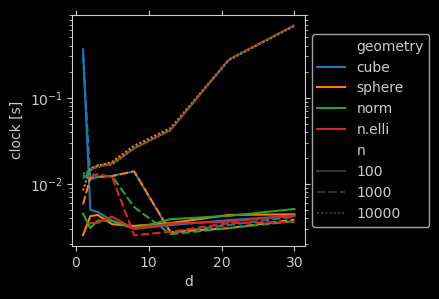

In [40]:
res = pd.read_csv('numba_gpu.csv')
plot_time(res, fn='numba_gpu.pdf')

# Use Pytorch

Numpy-like functionality on GPU canbe achieved by:
- pyTorch (our choice for the demo)
- cuPy
- Tensorflow

Really old, abandonned projects:
- gnumpy
- pyCUDA

Pros:
- use high level functions
- same code both on CPU ang GPU

Cons:
- no out of the box solution for our task
- more difficult to control data flow (memory need, processing)

Requirements install (version as of 2023):
```sh
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
```

In [63]:
import torch

def _prep_gpu_tensors(
    points_h: np.ndarray, queries_h: np.ndarray,
    k: int, p_norm: float, device: str,
):
    batch_size = 512  # todo
    N = queries_h.shape[0]
    points_d = torch.tensor(points_h, device=device).unsqueeze(0)
    queries_d = torch.tensor(queries_h, device=device).unsqueeze(0)
    conf = batch_size, N, k  # brute uses k only (hang on...)
    args = points_d, queries_d, p_norm
    return conf, args

def gpu_torch_brute(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0, device='cuda'
):
    conf, args = _prep_gpu_tensors(points, queries, k, p_norm, device)
    _, _, k, = conf
    points_d, queries_d, p_norm = args
    distances_d = torch.cdist(
        queries_d, points_d, p_norm,
        compute_mode='donot_use_mm_for_euclid_dist')
    distances_d, indices_d = torch.sort(distances_d, axis=-1)
    # try to minimize copied data by slicing on device (not contiguous mem)
    indices_h = indices_d[0, :, :k].cpu()
    distances_h = distances_d[0, :, :k].cpu()
    del indices_d, distances_d
    try:
        torch.cuda.empty_cache()
    except:
        pass
    return indices_h.numpy(), distances_h.numpy()

def gpu_torch_row(
    points: np.ndarray, queries: np.ndarray,
    k: int, p_norm: float = 2.0, device='cuda'
):
    conf, args = _prep_gpu_tensors(points, queries, k, p_norm, device)
    batch_size, N, k = conf
    points_d, queries_d, p_norm = args
    indices_h = np.empty((N, k), dtype=int)
    distances_h = np.empty((N, k), dtype=points.dtype)
    # todo transfer queries on demand (points have to be all there to sort)
    for i in range((N + batch_size - 1) // batch_size):
        sl = slice(i * batch_size, (i + 1) * batch_size)
        distances_d = torch.cdist(
            queries_d[:, sl], points_d, p_norm,
            compute_mode='donot_use_mm_for_euclid_dist')
        distances_d, indices_d = torch.topk(distances_d, k, sorted=True, axis=-1)
        # try to minimize copied data by slicing on device (not contiguous mem)
        indices_h[sl] = indices_d[0, :, :k].cpu()
        distances_h[sl] = distances_d[0, :, :k].cpu()
        del indices_d, distances_d
        try:
            torch.cuda.empty_cache()
        except:
            pass
    return indices_h, distances_h

In [64]:
res = measure_time(gpu_torch_row, make_data(ds=[0]), dtype=np.float32)
res.to_csv('torch_gpu.csv')

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
res = pd.read_csv('torch_gpu.csv')
plot_time(res, fn='torch_gpu.pdf')

  0%|          | 0/93 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

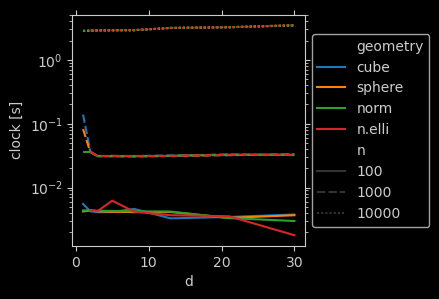

In [62]:
res = measure_time(gpu_torch_row, make_data(ds=[0]), dtype=np.float32, p_norm=2.001)
plot_time(res, fn='torch_gpu21.pdf')

(<Figure size 300x300 with 1 Axes>, <Axes: xlabel='d', ylabel='clock [s]'>)

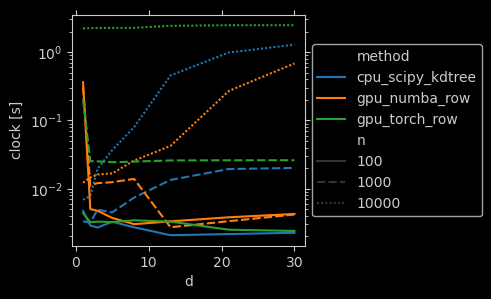

In [85]:
collected_gpu = collect_data(['kdtree_basic.csv', 'numba_gpu.csv', 'torch_gpu.csv'])
plot_time(collected_gpu[collected_gpu['geometry']=='cube'], 'collected_gpu.pdf', hue='method')